# Mini-Projet `MNIST`
Auteurs: *Emilie GALLAND*, *Léo BRENDLE*, *Fouad AFANE*


## Introduction

Le jeu de données MNIST est un classique du machine learning. Il contient des images de chiffres manuscrits (de 0 à 9) utilisées pour des tâches de reconnaissance automatique. Ce jeu de données comprend 60 000 exemples pour l’apprentissage et 10 000 pour le test. Chaque image fait 28×28 pixels, soit 784 variables par observation.

L’objectif de ce travail est de comparer plusieurs méthodes de classification sur ce jeu de données. Les modèles seront entraînés sur l’échantillon train et testés sur l’échantillon test. Lorsque ce sera utile, les hyperparamètres seront ajustés par validation croisée à 10 plis.
On utilisera des méthodes linéaires et non linéaires, en mode multiclasse direct ou avec une approche One-Versus-All.

**Plan**
1. Description du jeu de données
2. k plus proches voisins (k-NN)
3. Régression logistique
4. Analyse discriminante linéaire (LDA)
5. Random Forest
6. SVM à noyau gaussien
7. XGBoost
8. Comparaison et conclusion

## Chargement des librairies et des données

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

col_names = ['Y'] + [f'X{i}' for i in range(1, 785)]
mnist_train = pd.read_csv("mnist_train.csv", sep=",", names=col_names, header=None)
mnist_test = pd.read_csv("mnist_test.csv", sep=",", names=col_names, header=None)

mnist_train['Y'] = mnist_train['Y'].astype('category')
mnist_test['Y'] = mnist_test['Y'].astype('category')

## 1. Jeu de données

Le jeu de données MNIST (Modified National Institute of Standards and Technology) est une grande base d'images représentant des chiffres écrits à la main. Il est souvent utilisé en intelligence artificielle pour tester les performances de modèles, pour des tâches comme le débruitage d'images ou la vision par ordinateur par exemple.

In [3]:
np.shape(mnist_train), np.shape(mnist_test)

((60000, 785), (10000, 785))

mnist_train est un data frame de taille 60000 $\times$ 785. Les variables sont des variables quantitatives avec Y la vraie valeur du chiffre écrit et les variables X, sont des variables qui représentent les intensités des pixels (entre 0 et 1, 0 : noir, 1 : blanc). Chaque ligne représente donc une image en noir et blanc au format 28x28 pixels, ainsi que le chiffre manuscrit qui est représenté.

De même mnist_test est un data frame de taille 10000 $\times$ 785. On a donc environ 14% des valeurs qui sont dans le jeu test afin d'évaluer la qualité des modèles entrainés sur mnist_train.

## 2. Méthodes des k plus proches voisins

Dans cette partie, on souhaite appliquer la méthode des k plus proches voisins . \
Concrêtement, pour prédire la classe d'un point $x$, on choisit la classe majoritaire de ses $k$ plus proches voisins, c'est à dire:
$$
\hat{y} = \arg\max_{C} \operatorname{card}\left\{ i \mid Y_i = C,\, X_i \in N_k(x) \right\}
$$ 
où $N_k(x)$ est l'ensemble des $k$ plus proches voisins de $x$, $Y_i$ la classe de l'observation $i$.


In [4]:
# on commence par centrer et réduire les variables X
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(mnist_train.iloc[:,1:])
X_scaled_test = scaler.transform(mnist_test.iloc[:,1:]) # on utilise la normalisation avec les paramètres du jeu d'entrainement pour éviter un biais
Y_train = mnist_train.iloc[:,0]
Y_test = mnist_test.iloc[:,0]

# on applique la méthode des K plus proches voisins avec une grille d'hyperparamètres n_neighbors
param_grid = {'n_neighbors' : range(1,7)}
models_knn = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1).fit(X_scaled_train, Y_train)
cv_results = pd.DataFrame(models_knn.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.999519,0.014794,67.442205,0.315639,1,{'n_neighbors': 1},0.938167,0.943667,0.942500,0.939500,0.947333,0.942233,0.003229,2
1,5.983714,0.027670,67.660969,0.579578,2,{'n_neighbors': 2},0.931417,0.930417,0.934083,0.930750,0.937667,0.932867,0.002724,6
2,2.949810,2.483739,69.048575,1.716884,3,{'n_neighbors': 3},0.941583,0.943917,0.944917,0.938333,0.945167,0.942783,0.002560,1
3,1.025193,0.024684,70.868709,0.699576,4,{'n_neighbors': 4},0.938917,0.942083,0.942417,0.936667,0.944250,0.940867,0.002712,4
4,1.093068,0.021746,62.421877,15.368289,5,{'n_neighbors': 5},0.941083,0.942917,0.943333,0.936333,0.946583,0.942050,0.003363,3
5,0.929946,0.150186,30.965478,0.260762,6,{'n_neighbors': 6},0.939167,0.941583,0.941250,0.934750,0.945750,0.940500,0.003582,5


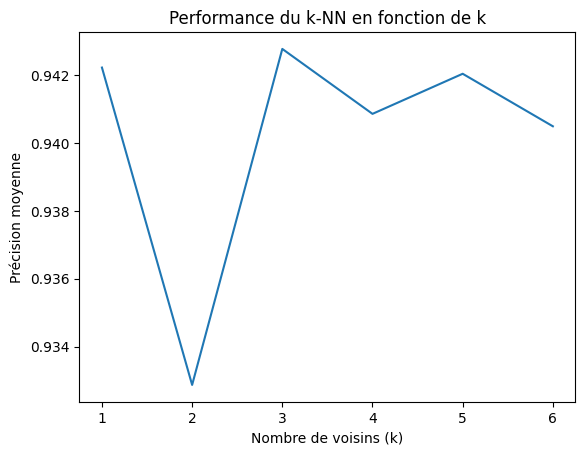

In [5]:
plt.plot(cv_results['param_n_neighbors'], cv_results['mean_test_score'])
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Précision moyenne")
plt.title("Performance du k-NN en fonction de k")
plt.show()

On voit que la meilleure précision est atteinte pour le modèle avec k = 2. Calculons à présent la précision du modèle sur l'échantillon d'entrainement et sur l'échantillon test.

In [6]:
best_model_knn = models_knn.best_estimator_
prec_test_knn = accuracy_score(best_model_knn.predict(X_scaled_test), Y_test)
prec_train_knn = accuracy_score(best_model_knn.predict(X_scaled_train), Y_train)
print(f"La précision moyenne du modèle des plus proches voisins sur l'échantillon d'apprentissage est de {prec_train_knn:.3f} et de {prec_test_knn:.3f} sur l'échantillon test")

La précision moyenne du modèle des plus proches voisins sur l'échantillon d'apprentissage est de 0.973 et de 0.945 sur l'échantillon test


## 3. Modèles de régression logistique

On applique un modèle de régression logistique.
Le modèle peut s'écrire :  
$\hat{y} = \arg\max_{C} \mathbb{P}(Y = C \mid X)$

In [7]:
# modèle de régression logistique : création et entrainement du modèle
model_reg_log = LogisticRegression(max_iter = 100, solver = 'newton-cg')
model_reg_log.fit(X_scaled_train, Y_train)
# predictions
y_pred_test = model_reg_log.predict(X_scaled_test)
y_pred_train = model_reg_log.predict(X_scaled_train)
# evaluation des performances
prec_test_log = accuracy_score(y_pred_test, Y_test)
prec_train_log = accuracy_score(y_pred_train, Y_train)
print(f"La précision du moyenne du modèle de régression logistique sur l'échantillon d'apprentissage est de {prec_train_log:.3f} et de {prec_test_log:.3f} sur l'échantillon test")

La précision du moyenne du modèle de régression logistique sur l'échantillon d'apprentissage est de 0.944 et de 0.921 sur l'échantillon test


Affichons les 9 premières images du jeu de test, ainsi que leurs prédictions par le modèle de régression logistique :

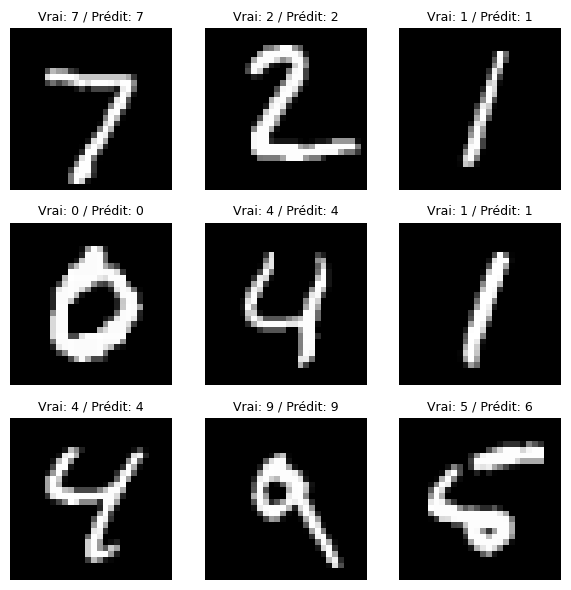

In [8]:
plt.figure(figsize=(6, 6))
for i in range(9):
    # extraction de l'image (28x28)
    M = mnist_test.iloc[i, 1:].to_numpy().reshape((28, 28))
    true_label = Y_test.iloc[i]
    predicted_label = y_pred_test[i]

    plt.subplot(3, 3, i + 1)
    plt.imshow(M, cmap="gray", interpolation="nearest")

    plt.title(f"Vrai: {true_label} / Prédit: {predicted_label}", fontsize=9)
    plt.axis("off")

plt.tight_layout()

## 4. Analyse discriminante linéaire (LDA)

Pour l'analyse discriminante linéaire, le raisonnement est de modéliser conjointement les variables $(X, Y)$. On suppose que $X$, conditionnellement à la classe $Y = j$, suit une loi normale multivariée de covariance $\Sigma$ commune pour toutes les classes. 
Le modèle s’écrit alors :
$$
f(j, x) = \pi_j g_{\mu_j, \Sigma}(x),
$$
où $\pi_j = \mathbb{P}(Y = j)$ et $g_{\mu_j, \Sigma}(x)$ est la densité normale conditionnelle.  
Le classifieur LDA assigne alors chaque observation à la classe qui maximise cette probabilité :
$$
\hat{y} = \arg\max_j \pi_j g_{\mu_j, \Sigma}(x).
$$


In [9]:
# initialisation et ajustement du modèle
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_scaled_train, Y_train)
# prédiction
y_pred_train_lda = LDA.predict(X_scaled_train)
y_pred_test_lda = LDA.predict(X_scaled_test)
# évaluation
prec_train_lda = accuracy_score(Y_train, y_pred_train_lda)
prec_test_lda = accuracy_score(Y_test, y_pred_test_lda)
print(f"La précision du moyenne d'analyse discriminante linéaire sur l'échantillon d'apprentissage est de {prec_train_lda:.3f} et de {prec_test_lda:.3f} sur l'échantillon test")

La précision du moyenne d'analyse discriminante linéaire sur l'échantillon d'apprentissage est de 0.871 et de 0.873 sur l'échantillon test


Jusqu'à présent, c'est la méthode des plus proches voisins qui donne les meilleurs résultats. Le modèle le moins performant sur notre jeu de données est l'analyse discriminante linéaire.

## 5. Random Forest

Dans cette partie, nous appliquons la méthode **Random Forest** à notre jeu de données MNIST. Ce modèle d’ensemble repose sur la combinaison de plusieurs arbres de décision, chacun étant entraîné sur un sous-échantillon des données et un sous-ensemble de variables.
L'objectif est de contrôler le nombre de variables testées à chaque séparation dans les arbres. Ainsi , on pourra optimiser la diversité des arbres et éviter le surapprentissage.
Nous utilisons GridSearchCV de scikit-learn pour tester différentes valeurs de max_features : 20,50,100...
Nous combinons également cela avec une validation croisée à 5 plis sur l’échantillon d’apprentissage, ce qui permet d’évaluer la robustesse du modèle pour chaque valeur testée.



In [ ]:
# grille d'hyperparamètres pour max_features
param_grid = {
    'max_features': [20, 50, 100, 200]
}
# modèle de base
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# validation croisée avec GridSearch
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_scaled_train, Y_train)
best_rf = grid_rf.best_estimator_
print("Meilleur paramètre max_features :", grid_rf.best_params_)

# prédiction
y_pred_rf = best_rf.predict(X_scaled_test)

# évaluation de la performance
prec_test_rf = accuracy_score(Y_test, y_pred_rf)
print(f"Le taux de bonne classification de random forest est de {prec_test_rf:.3f} sur l'échantillon test")

Meilleur paramètre max_features : {'max_features': 100}
Le taux de bonne classification de random forest est de 0.967 sur l'échantillon test


### Conclusion
La méthode Random Forest s’est révélée particulièrement efficace pour la reconnaissance de chiffres manuscrits.
L’optimisation de l’hyperparamètre max_features par validation croisée a permis d’obtenir de très bonnes performances, avec un taux de bonne classification de 96.7 % sur l’échantillon test.

## 6. Support Vector Machine (SVM) à noyau gaussien

Après avoir appliqué un modèle d’ensemble tel que la Random Forest, il est pertinent d’explorer une méthode complètement différente comme le **Support Vector Machine (SVM)**. Contrairement aux arbres de décision, le SVM repose sur une approche géométrique : il cherche à maximiser la marge entre les différentes classes dans un espace de représentation des données.

Dans le cas du dataset MNIST, les classes ne sont pas toujours séparables linéairement. Nous utilisons donc ici un **noyau gaussien (ou RBF)**, qui permet au SVM de transformer les données dans un espace de plus grande dimension où une séparation devient possible. Ce choix est appuyé par les résultats expérimentaux présentés en cours (Chapitre 4: Support Vector Machine, p.20) le SVM radial obtient une erreur test de 5.4 %, meilleure que celle du SVM linéaire (6.5 %) et très proche de la Random Forest (5.9 %). Cela montre sa capacité à bien généraliser sans surajustement.

### Objectif :
L’objectif est d’optimiser le paramètre gamma du noyau RBF. Ce paramètre contrôle l’influence d’un point d’entraînement donné :  
- un **gamma élevé** produit un modèle plus complexe et potentiellement surajusté,  
- un **gamma faible** donne un modèle plus lisse.

Nous testons plusieurs valeurs (1e-3, 1e-2, 1e-1) à l’aide de GridSearchCV avec validation croisée à 5 plis pour limiter le temps de calcul. Egalement, nous nous sommes rendu compte qu'avec 3 paramètres et 5 plis le temps de calcul était quand même de plusieurs heures. On choisit, pour la sélection du paramètre gamma par validation croisée seulement, de réduire le jeu de données d'entrainement.


In [14]:
from sklearn.svm import SVC
# grille d'hyperparamètres pour max_features
param_grid = {
    'gamma': [1e-3, 1e-2, 1e-1]
}
# sous échantillonnage
X_train_2 = X_scaled_train[:10000]
Y_train_2 = Y_train[:10000]
# modèle de base
svm = SVC(kernel='rbf')
# validation croisée avec GridSearch
grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_2, Y_train_2)
print("Meilleur paramètre gamma :", grid_svm.best_params_)

# entrainement sut tout le jeu de données et prédiction
best_gamma = grid_svm.best_params_['gamma']
best_svm = SVC(kernel='rbf', gamma=best_gamma)
best_svm.fit(X_scaled_train, Y_train)
y_pred_svm = best_svm.predict(X_scaled_test)

# évaluation de la performance
prec_test_svm = accuracy_score(Y_test, y_pred_svm)
print(f"Le taux de bonne classification de SVM est de {prec_test_svm:.3f} sur l'échantillon test")

Meilleur paramètre gamma : {'gamma': 0.001}
Le taux de bonne classification de SVM est de 0.966 sur l'échantillon test


### Conclusion

L’application du SVM à noyau gaussien au dataset MNIST nous permet d’explorer une méthode géométrique, fondamentalement différente des arbres d’ensemble. 
Grâce à l’optimisation du paramètre gamma par validation croisée, le modèle atteint une précision de 96.6 % sur les données de test. Ce résultat suggère que le SVM a réussi à capter la complexité des chiffres manuscrits.

## 7. XG Boost

Après avoir testé la Random Forest et le SVM, nous appliquons à présent l’algorithme XGBoost, une méthode d’ensemble basée sur le Gradient Boosting. XGBoost est particulièrement réputé pour sa performance et sa capacité à gérer efficacement de grands volumes de données.

Contrairement à la Random Forest, XGBoost construit chaque arbre de manière séquentielle, en corrigeant les erreurs des arbres précédents. Cette approche permet un ajustement plus fin, au prix d’un temps de calcul plus important.

Notre objectif sera d'optimiser deux hyperparamètres clés : max_depth : profondeur maximale des arbres et n_estimators : nombre total d’arbres.

Nous avons utilisé GridSearchCV avec validation croisée à 5 plis pour maitriser le temps de calcul.

In [18]:
from xgboost import XGBClassifier

# Grille d'hyperparamètres à tester
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100]
}

# Modèle de base
xgb = XGBClassifier(
    eval_metric='mlogloss',   # métrique multi-classe par défaut
    random_state=42,
    n_jobs=-1
)

# GridSearchCV avec validation croisée 5 plis
grid_xgb = GridSearchCV(estimator=xgb,
                        param_grid=param_grid,
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1)

# Entraînement
grid_xgb.fit(X_scaled_train, Y_train)

# Meilleur modèle
best_xgb = grid_xgb.best_estimator_
print("Meilleurs hyperparamètres :", grid_xgb.best_params_)

# Prédictions sur les données de test
y_pred_xgb = best_xgb.predict(X_scaled_test)

# Évaluation
prec_test_xgb = accuracy_score(Y_test, y_pred_xgb)
print(f"Taux de bonne classification (XGBoost) : {prec_test_xgb:.4f}")


Meilleurs hyperparamètres : {'max_depth': 7, 'n_estimators': 100}
Taux de bonne classification (XGBoost) : 0.9782


### Conclusion

Les meilleurs paramètres trouvés : max_depth = 7, n_estimators = 100.

Taux de bonne classification sur le jeu test : 97,82 %.

Ce résultat est le meilleur parmi toutes les méthodes testées, grâce à un algorithme plus complexe.

## 8. Comparaison des méthodes et conclusion

Après avoir testé différentes approches de classification sur le jeu de données MNIST, nous pouvons comparer les performances obtenues sur l’échantillon de test grâces aux taux de bonne classification. Nous représentons ci dessous les résultats sous forme d'un diagramme en barres.

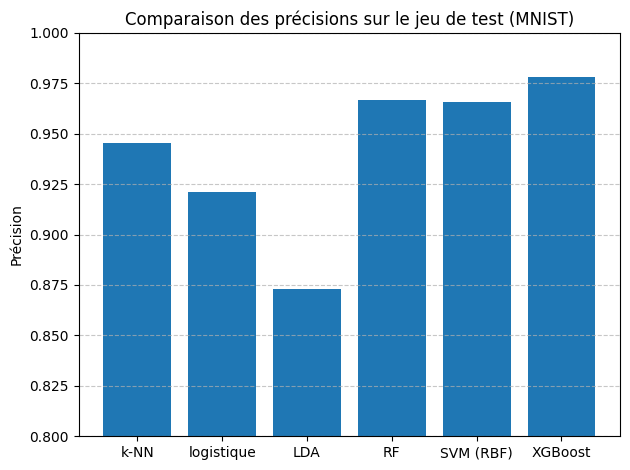

In [21]:
models = ['k-NN', 'logistique', 'LDA', 'RF', 'SVM (RBF)', 'XGBoost']
accuracies = [prec_test_knn, prec_test_log, prec_test_lda, prec_test_rf, prec_test_svm, prec_test_xgb]

bars = plt.bar(models, accuracies)
plt.title("Comparaison des précisions sur le jeu de test (MNIST)")
plt.ylabel("Précision")
plt.ylim(0.8, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

La comparaion des ces six méthodes de classification supervisée sur le jeu de données MNIST a montré que XGBoost domine nettement les autres méthodes avec une précision de presque 98% sur l'échantillon test, suivi de SVM et Random Forest avec des précisions proches de 96.5 %. La régression logistique et le k-NN offrent des résultats corrects, mais moins performants. LDA montre ses limites sur un jeu de données non linéaire.

Chaque méthode a ses avantages : les modèles d’ensemble comme XGBoost et la Random Forest sont efficaces sur ce type de données, tandis que les SVM nécessitent un temps de calcul plus important. La régression logistique et la méthode des plus proches voisins offrent des performances correctes (94% de précision) avec des ressources limitées.

Notre analyse met aussi en évidence l’importance de la validation croisée et de l’optimisation des hyperparamètres dans la réussite d’un modèle. On a vu que les performances des modèles de machine learning dépendent grandement du choix des hyperparamètres par rapport au jeu de données.
